In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

In [2]:
# Loading train dataset
train = pd.read_csv('train.csv')
train.shape # (57214, 49)

# Dropping the unnamed column
train = train.drop(columns = 'Unnamed: 0')
train.head(2)

encounter_id  patient_nbr             race  gender  age  admission_type_id  \
0       2278392      8222157        Caucasian  Female    5                  5   
1         64410     86047875  AfricanAmerican  Female   25                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital payer_code  \
0                        18                    1                 1          ?   
1                         1                    7                 2          ?   

   ...  citoglipton  insulin  glyburide-metformin  glipizide-metformin  \
0  ...           No       No                   No                   No   
1  ...           No       No                   No                   No   

   glimepiride-pioglitazone  metformin-rosiglitazone metformin-pioglitazone  \
0                        No                       No                     No   
1                        No                       No                     No   

  change diabetesMed  readmitted  
0     No          No          -1  
1     No         Yes          -1  

[2 rows x 48 columns]

In [3]:
# Loading test dataset 
test = pd.read_csv('test.csv')
test.shape # (14304, 49)

# Dropping the unnamed column
test = test.drop(columns = 'Unnamed: 0')

In [4]:
# Examining the distribution of the target var
train.readmitted.value_counts()

# Changing the values of the response variable in train data
train['readmitted'] = train['readmitted'].replace(-1, 0)

# Doing the same in the test data
test['readmitted'] = test['readmitted'].replace(-1, 0)

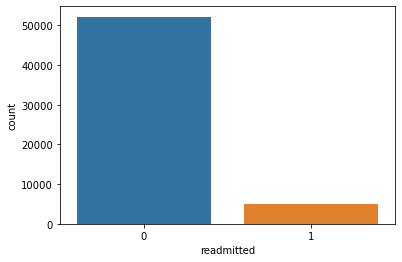

In [5]:
sns.countplot(x = 'readmitted', data = train);

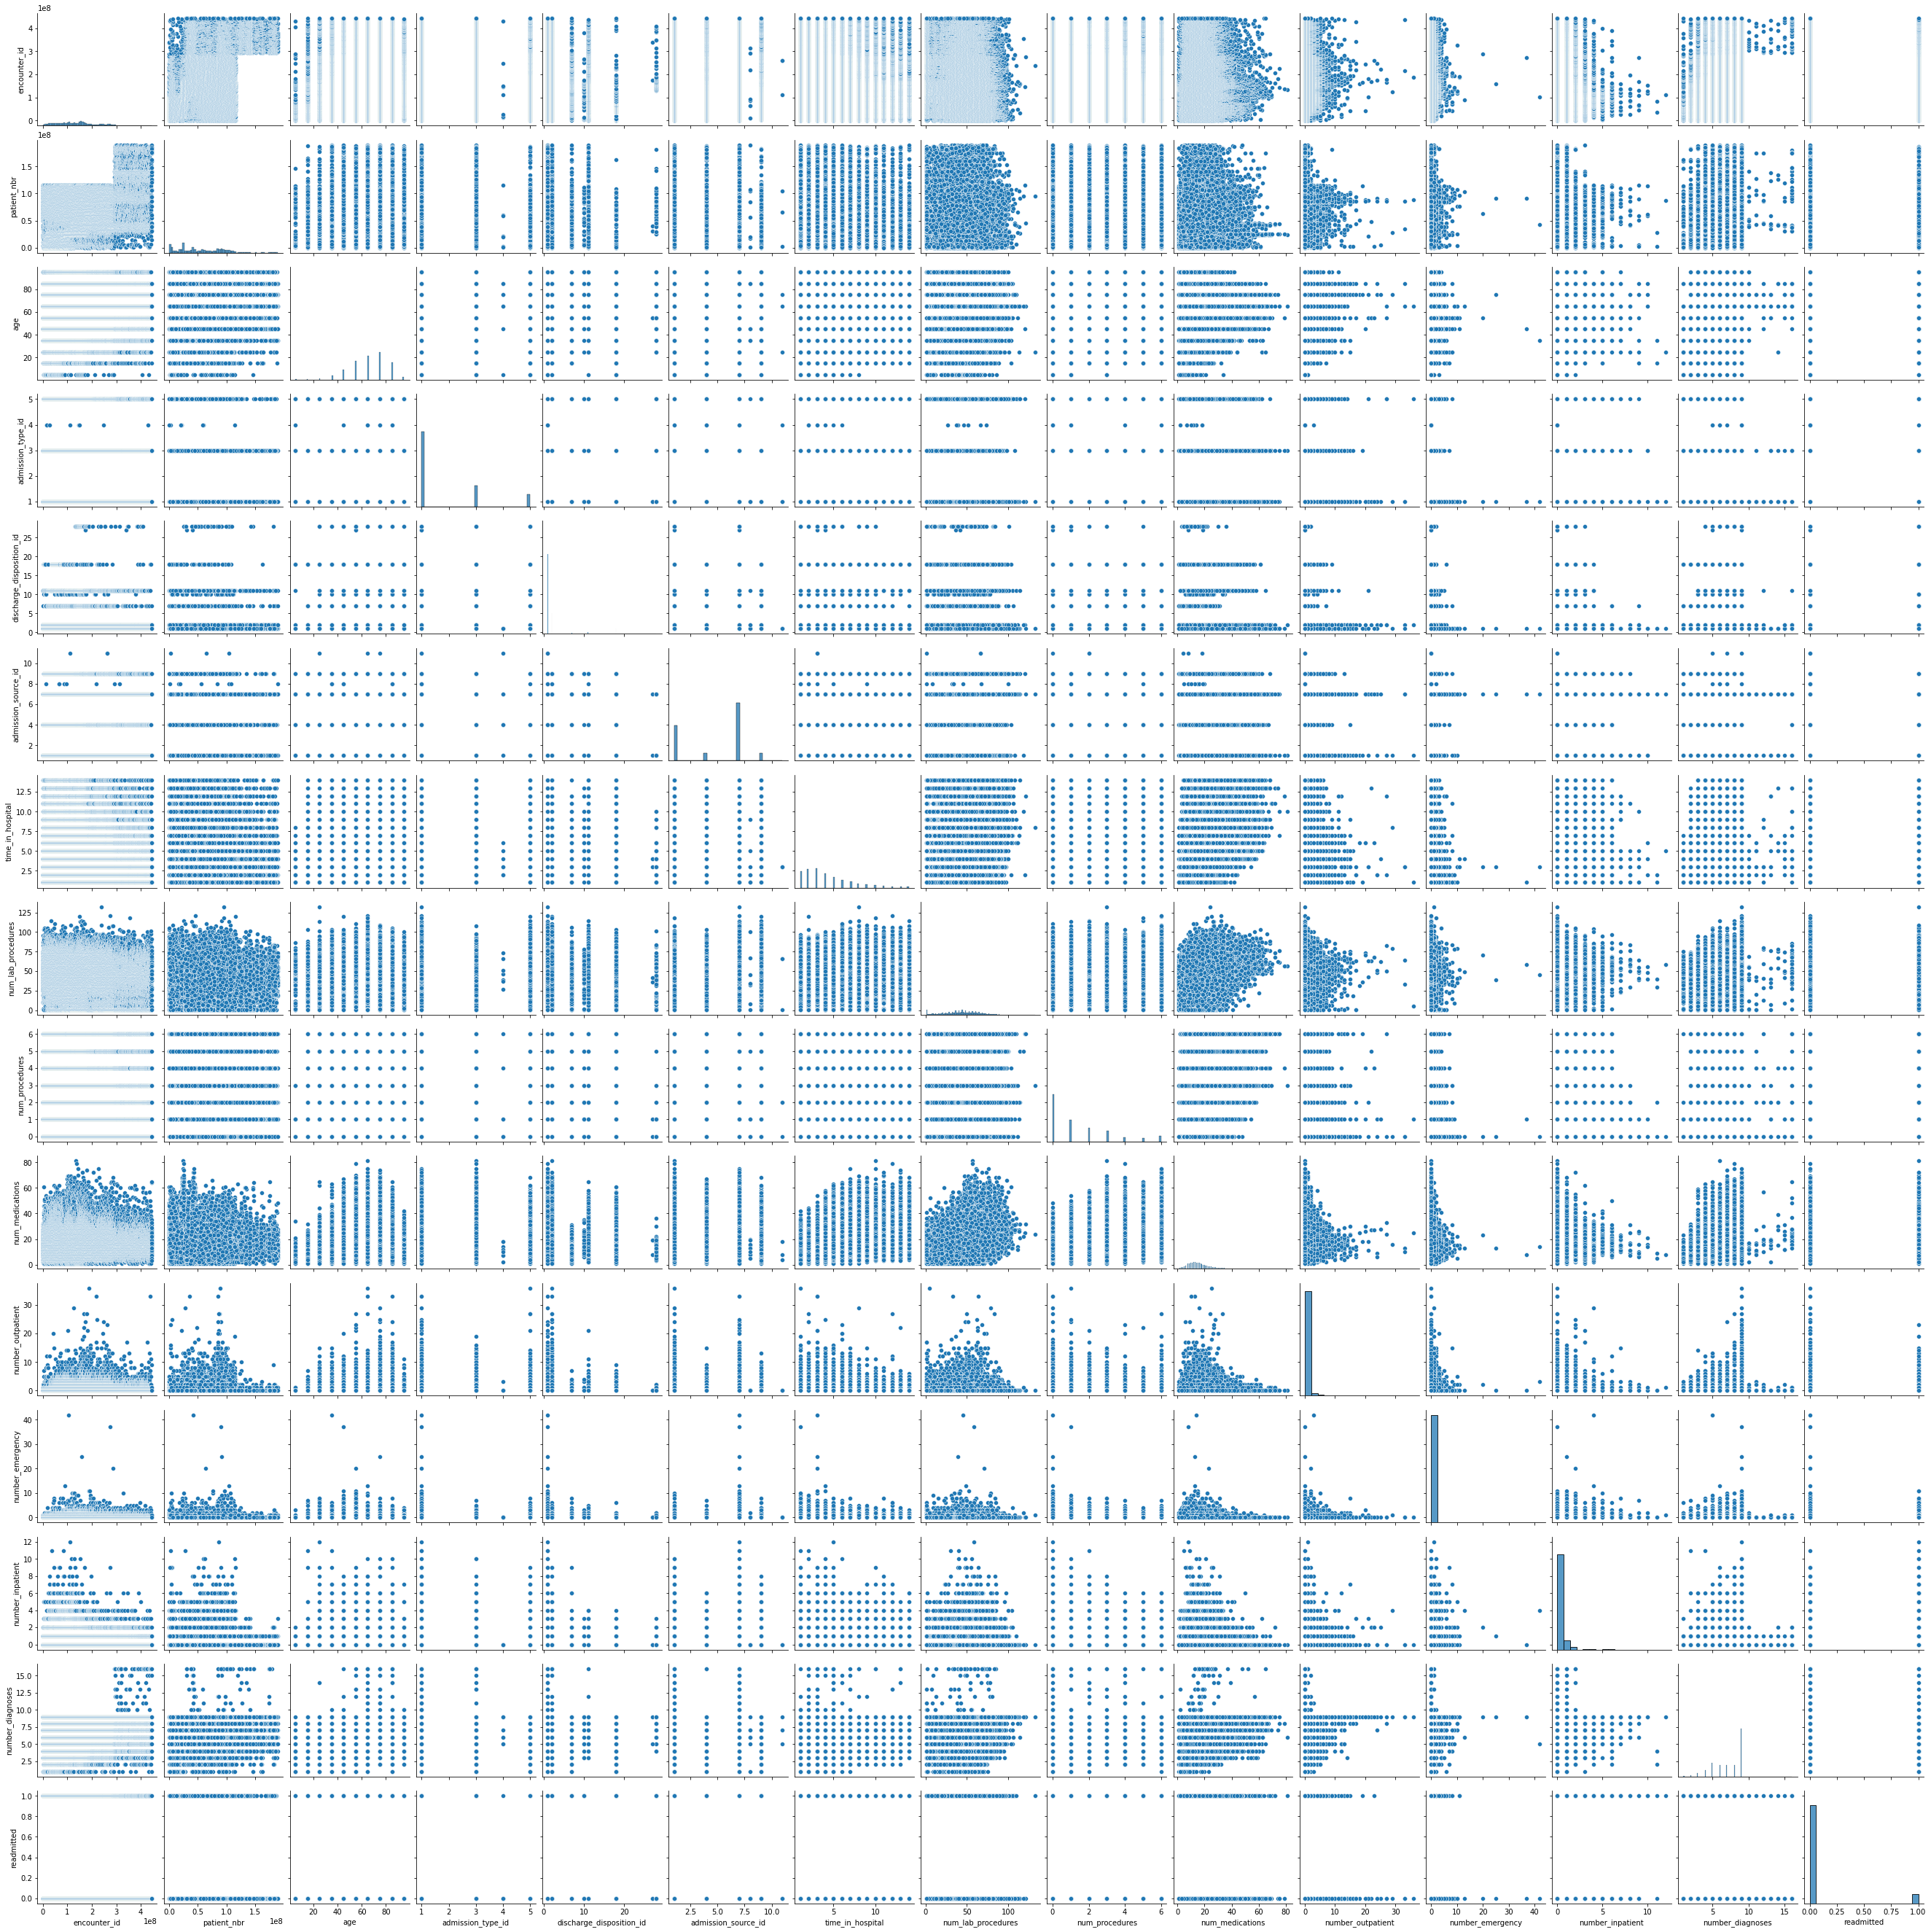

In [44]:
# Creating a pairplot of the varaibles in the data
sns.pairplot(data = train)

In [6]:
# Fitting a prelim model
logit_model = sm.logit(formula = 'readmitted~time_in_hospital+age+discharge_disposition_id+num_procedures+num_medications+number_emergency+number_inpatient+number_diagnoses', data = train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.292141
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                57214
Model:                          Logit   Df Residuals:                    57205
Method:                           MLE   Df Model:                            8
Date:                Thu, 16 Feb 2023   Pseudo R-squ.:                 0.02011
Time:                        14:42:08   Log-Likelihood:                -16715.
converged:                       True   LL-Null:                       -17058.
Covariance Type:            nonrobust   LLR p-value:                6.780e-143
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -3.5330      0.085    -41.540      0.000      -3.700      -3.366
time_in_hospital             0.0351      0.005      6.435      0.000       0.024       0.046
age                          0.0079      0.001      7.825      0.000       0.006       0.010
discharge_disposition_id     0.0123      0.004      3.329      0.001       0.005       0.020
num_procedures              -0.0261      0.009     -2.771      0.006      -0.045      -0.008
num_medications              0.0082      0.002      3.838      0.000       0.004       0.012
number_emergency             0.0700      0.022      3.166      0.002       0.027       0.113
number_inpatient             0.3502      0.018     19.984      0.000       0.316       0.385
number_diagnoses             0.0394      0.008      4.670      0.000       0.023       0.056
============================================================================================
"""

In [7]:
#Function to compute confusion matrix and prediction accuracy on training data
def confusion_matrix_train(model,cutoff=0.5):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

Classification accuracy = 91.2%


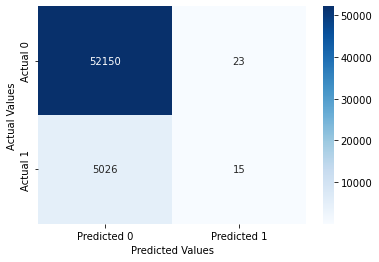

In [8]:
cm = confusion_matrix_train(logit_model)

In [9]:
# Function to compute confusion matrix and prediction accuracy on test data
def confusion_matrix_test(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

Classification accuracy = 91.2%


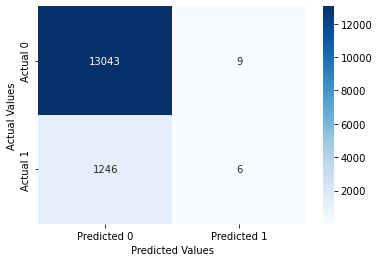

In [10]:
confusion_matrix_test(test, test.readmitted,logit_model)

In [15]:
from sklearn.metrics import roc_curve, auc

#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

Classification accuracy = 91.2%
Precision = 40.0%
TPR or Recall = 0.5%
FNR = 99.5%
FPR = 0.1%
ROC-AUC = 59.4%


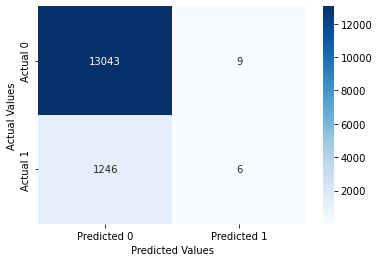

In [16]:
confusion_matrix_data(test,test.readmitted,logit_model)

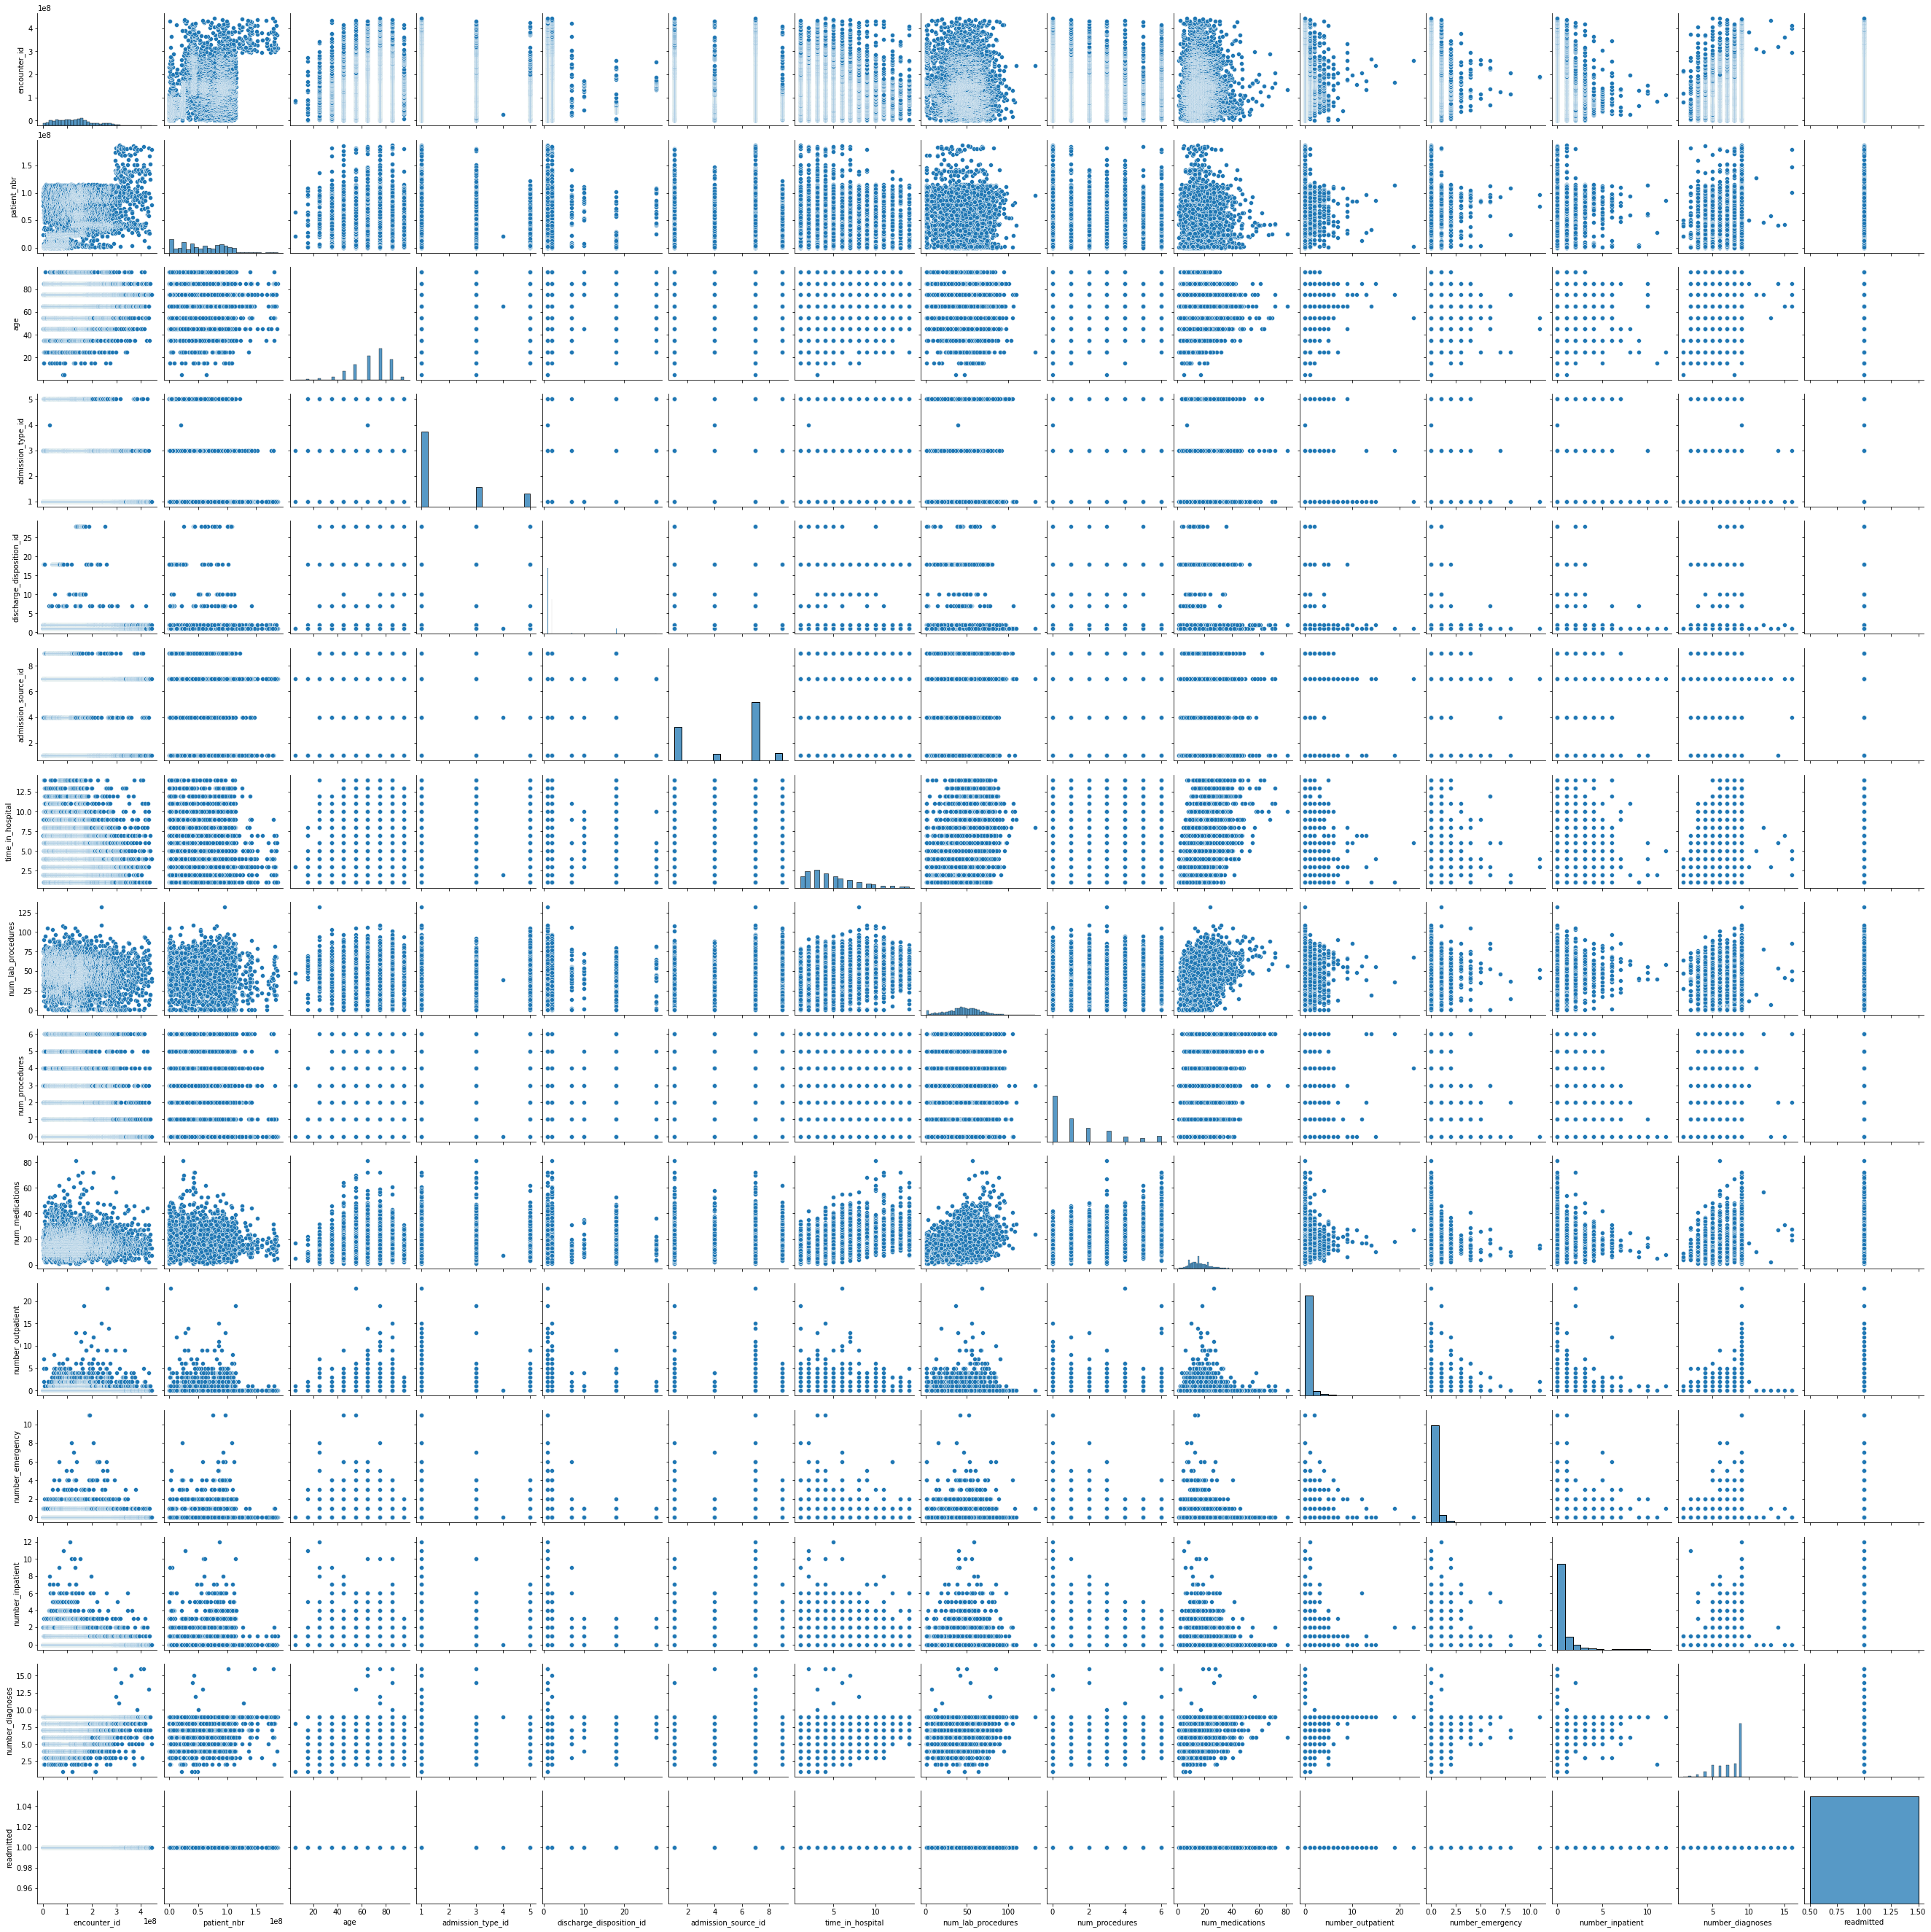

In [18]:
# Visualizing the vars when readmitted = 1
sns.pairplot(data = train[train['readmitted'] == 1])

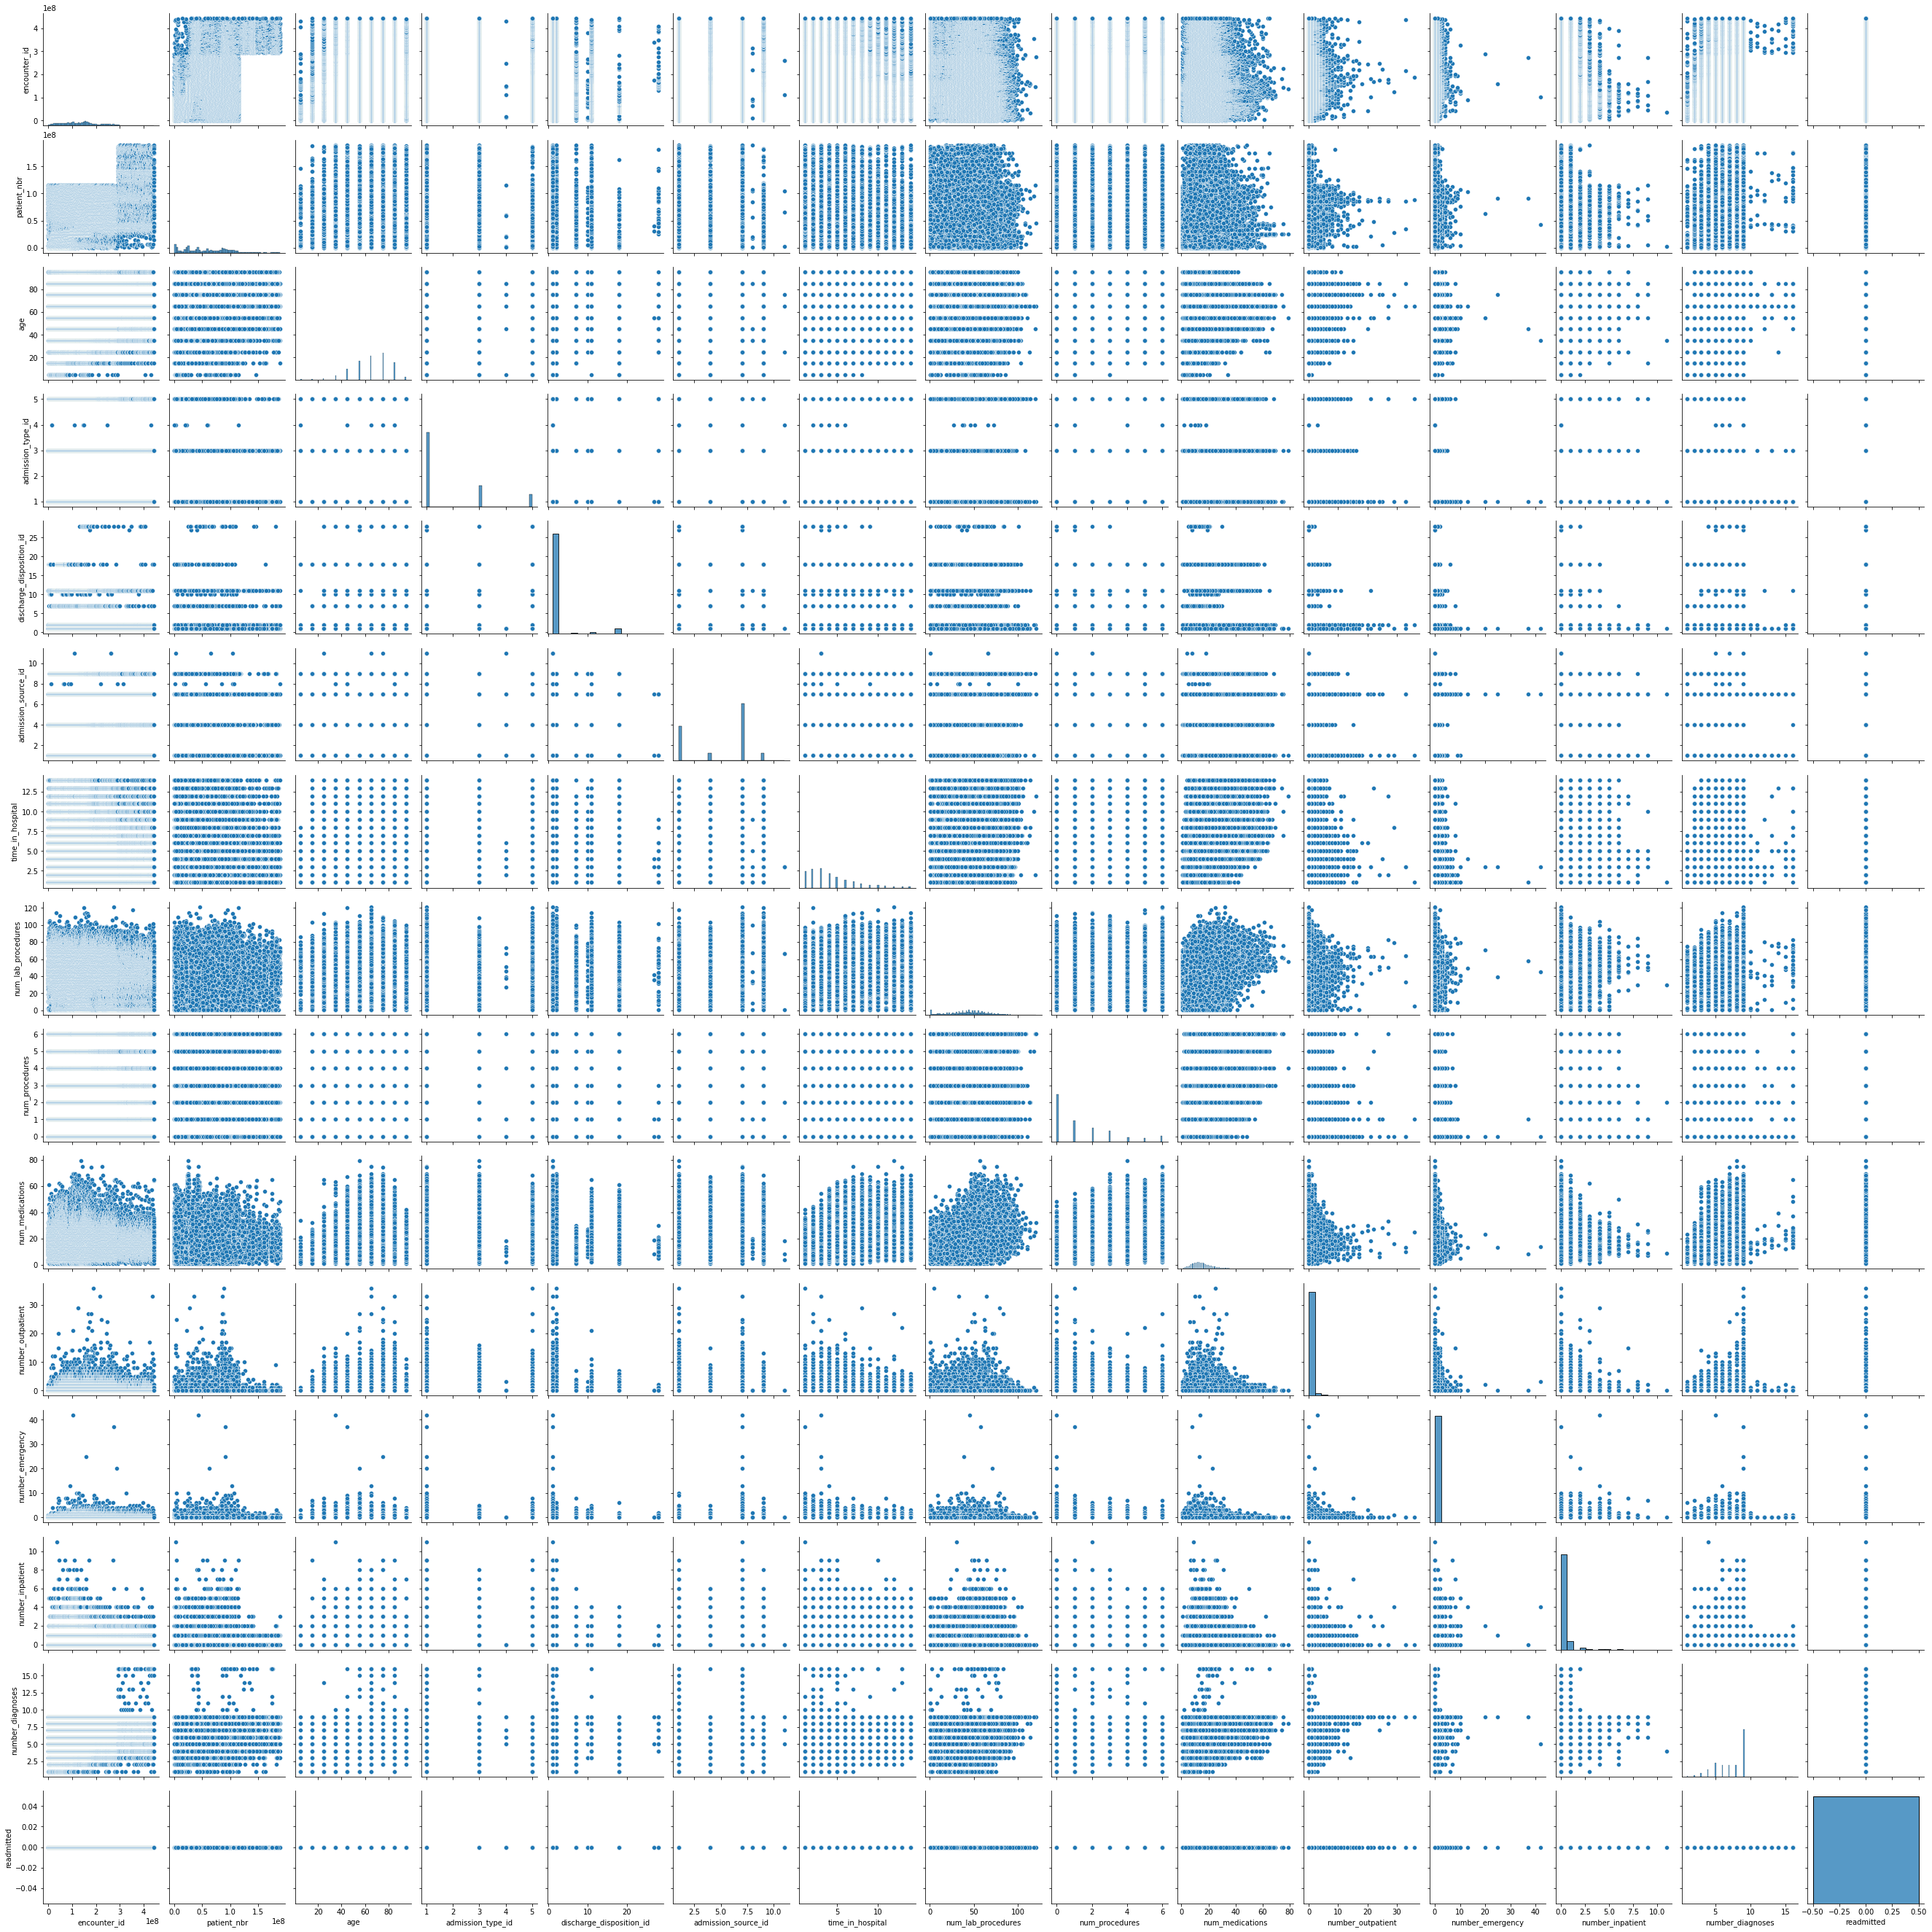

In [19]:
# Visualizing the vars when readmitted = 0
sns.pairplot(data = train[train['readmitted'] == 0])

<AxesSubplot:xlabel='readmitted', ylabel='admission_type_id'>

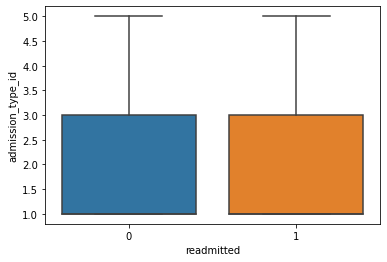

In [24]:
# Looking more into variable distributions (admission_type_id)
sns.boxplot(x = 'readmitted', y = 'admission_type_id',  data = train)

<AxesSubplot:xlabel='readmitted', ylabel='discharge_disposition_id'>

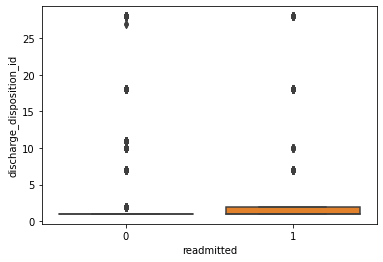

In [31]:
# Looking more into variable distributions (discharge_disposition_id) 
sns.boxplot(y = 'discharge_disposition_id', x = "readmitted", data = train)

<AxesSubplot:xlabel='readmitted', ylabel='admission_source_id'>

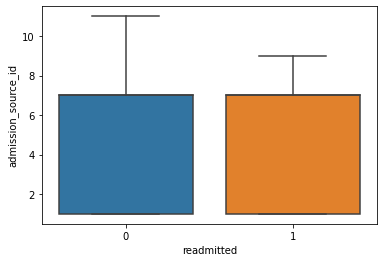

In [33]:
# Looking more into variable distributions (admission_source_id)
sns.boxplot(x = 'readmitted', y = 'admission_source_id',  data = train)

<AxesSubplot:xlabel='readmitted', ylabel='time_in_hospital'>

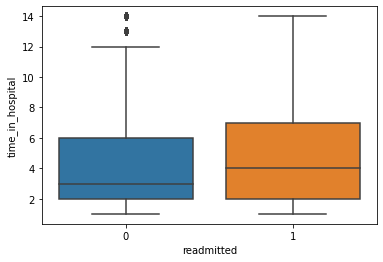

In [34]:
# Looking more into variable distributions (time_in_hospital)
sns.boxplot(x = 'readmitted', y = 'time_in_hospital',  data = train)

<AxesSubplot:xlabel='readmitted', ylabel='num_lab_procedures'>

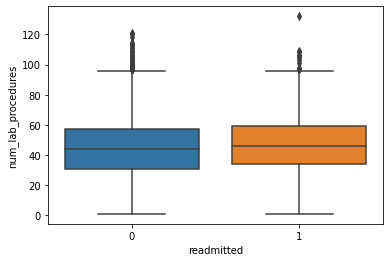

In [36]:
# Looking more into variable distributions (num_lab_procedures)
sns.boxplot(x = 'readmitted', y = 'num_lab_procedures',  data = train)

<AxesSubplot:xlabel='readmitted', ylabel='num_procedures'>

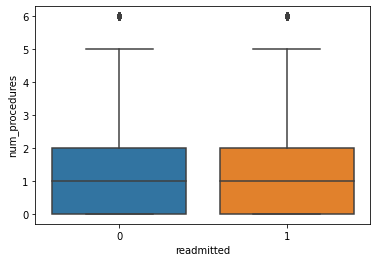

In [42]:
# Looking more into variable distributions (num_procedures)
sns.boxplot(x = 'readmitted', y = 'num_procedures',  data = train)

<AxesSubplot:xlabel='readmitted', ylabel='num_medications'>

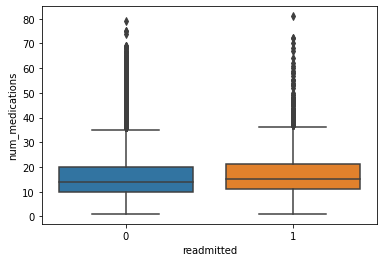

In [43]:
# Looking more into variable distributions (num_medications)
sns.boxplot(x = 'readmitted', y = 'num_medications',  data = train)

<AxesSubplot:xlabel='readmitted', ylabel='number_outpatient'>

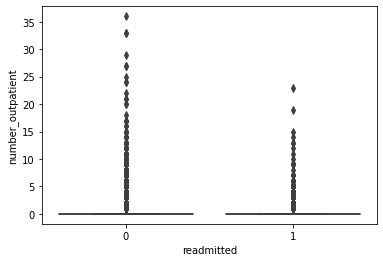

In [46]:
# Looking more into variable distributions (number_outpatient)
sns.boxplot(x = 'readmitted', y = 'number_outpatient',  data = train)

<AxesSubplot:xlabel='readmitted', ylabel='number_emergency'>

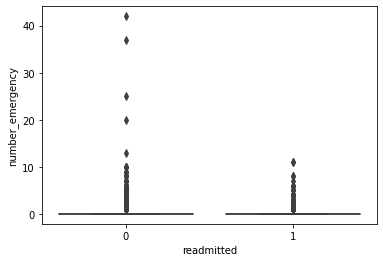

In [47]:
# Looking more into variable distributions (number_emergency)
sns.boxplot(x = 'readmitted', y = 'number_emergency',  data = train)

<AxesSubplot:xlabel='readmitted', ylabel='number_inpatient'>

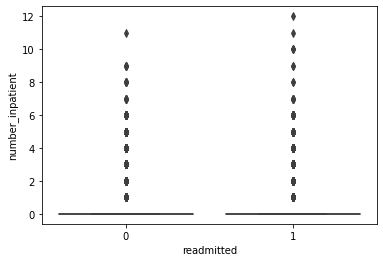

In [48]:
# Looking more into variable distributions (number_inpatient)
sns.boxplot(x = 'readmitted', y = 'number_inpatient',  data = train)

<AxesSubplot:xlabel='readmitted', ylabel='number_diagnoses'>

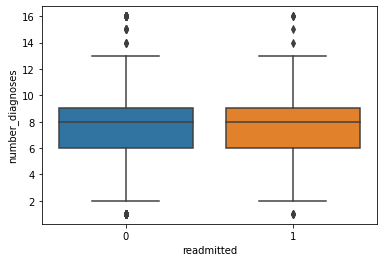

In [50]:
# Looking more into variable distributions (number_diagnoses)
sns.boxplot(x = 'readmitted', y = 'number_diagnoses',  data = train)

In [53]:
# Refitting the model with these findings in mind 
logit_model2 = sm.logit(formula = 'readmitted~time_in_hospital+age+discharge_disposition_id+admission_source_id+number_outpatient+number_emergency+number_inpatient+number_outpatient', data = train).fit() #Developing logistic regression model
logit_model2.summary()

Optimization terminated successfully.
         Current function value: 0.292532
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                57214
Model:                          Logit   Df Residuals:                    57206
Method:                           MLE   Df Model:                            7
Date:                Thu, 16 Feb 2023   Pseudo R-squ.:                 0.01880
Time:                        15:12:15   Log-Likelihood:                -16737.
converged:                       True   LL-Null:                       -17058.
Covariance Type:            nonrobust   LLR p-value:                2.864e-134
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -3.2720      0.073    -44.631      0.000      -3.416      -3.128
time_in_hospital             0.0474      0.005      9.946      0.000       0.038       0.057
age                          0.0089      0.001      9.063      0.000       0.007       0.011
discharge_disposition_id     0.0110      0.004      2.971      0.003       0.004       0.018
admission_source_id          0.0005      0.005      0.106      0.915      -0.010       0.011
number_outpatient            0.0039      0.013      0.293      0.769      -0.022       0.030
number_emergency             0.0780      0.022      3.470      0.001       0.034       0.122
number_inpatient             0.3559      0.018     20.272      0.000       0.322       0.390
============================================================================================
"""

Classification accuracy = 91.2%
Precision = 37.5%
TPR or Recall = 0.5%
FNR = 99.5%
FPR = 0.1%
ROC-AUC = 60.0%


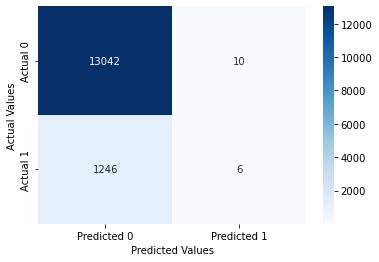

In [54]:
confusion_matrix_data(test,test.readmitted,logit_model)

# Note: refitting the model...
    # decreased precision
    # increased ROC-AUC slightly 
    # did nothing for recall, FNR, or FPR